In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/london-bike-sharing-dataset/london_merged.csv


In [2]:
df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv', parse_dates=['timestamp'])
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [4]:
df.shape

(17414, 10)

In [5]:
train = df.iloc[:17000, 1:2]
test = df.iloc[17000:17414, 1:2]

In [6]:
print(train.shape)
print(test.shape)

(17000, 1)
(414, 1)


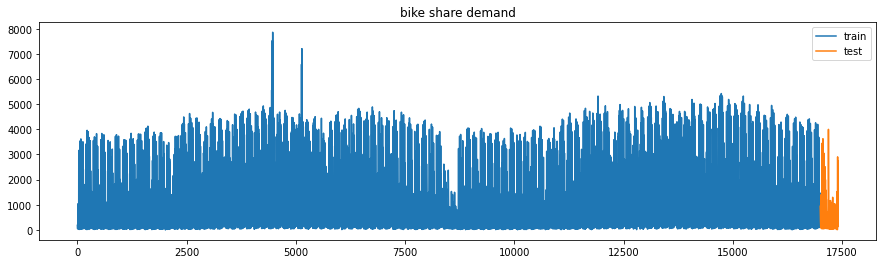

In [7]:
df['cnt'][:17000].plot(figsize=(15,4), legend=True)
df['cnt'][17000:].plot(figsize=(15,4), legend=True)
plt.legend(['train', 'test'])
plt.title('bike share demand')
plt.show()

In [8]:
# 차수 추정

from statsmodels.tsa.stattools import pacf
pacf = pacf(df['cnt'], nlags=42, method='ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713  0.13216383  0.36316314  0.36823577
  0.17363431 -0.40134782  0.25244062 -0.0346957   0.06394955  0.0401744
  0.03309681 -0.05199095 -0.14022104 -0.13320839  0.08181519 -0.01496363
 -0.04990686 -0.03495871 -0.01086392  0.04519191  0.01509356  0.03339241
  0.09344723]


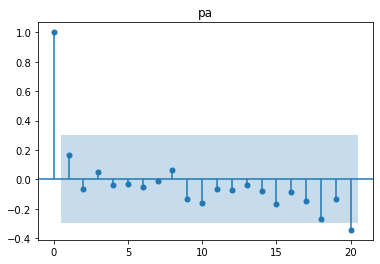

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(pacf, lags=20, method='ols', title='pa').show()

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train)

In [11]:
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [12]:
X_train = []
y_train = []

for i in range(1, 17000):
    X_train.append(train_scaled[i-1:i, 0])
    y_train.append(train_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(16999, 1)

In [14]:
# 3차원 배열로 reshape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(16999, 1, 1)

In [15]:
# RNN 모형
# 특징: 과거의 정보를 보관

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import SimpleRNN

2021-09-13 11:02:38.487434: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-13 11:02:38.487516: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [16]:
rnn = Sequential()
rnn.add(SimpleRNN(activation='relu', units=6, input_shape=(1,1)))
rnn.add(Dense(activation='linear', units=1))

2021-09-13 11:02:40.520433: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-13 11:02:40.520823: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-13 11:02:40.520855: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-13 11:02:40.520892: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3d172b37710b): /proc/driver/nvidia/version does not exist
2021-09-13 11:02:40.521231: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [17]:
print(rnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 6)                 48        
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [19]:
rnn.fit(X_train, y_train, batch_size=1, epochs=2)

2021-09-13 11:02:40.701980: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-13 11:02:40.702881: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz


Epoch 1/2
16999/16999 [==============================] - 22s 1ms/step - loss: 0.0093 - mse: 0.0093
Epoch 2/2
16999/16999 [==============================] - 20s 1ms/step - loss: 0.0077 - mse: 0.0077


In [20]:
inputs = sc.transform(test)
inputs.shape

(414, 1)

In [21]:
X_test = []
for i in range(1, 415):
    X_test.append(inputs[i-1:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test.shape

(414, 1, 1)

In [22]:
rnn = rnn.predict(X_test)
rnn = sc.inverse_transform(rnn) # 스케일링했던 값 복원

In [23]:
test1 = pd.DataFrame(test)
rnn1 = pd.DataFrame(rnn)

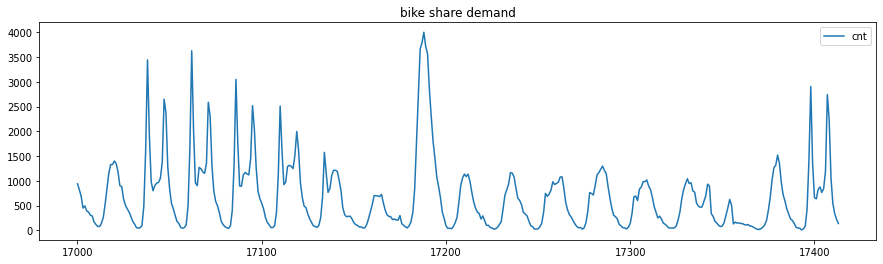

In [24]:
# 자전거 이용객수 실측값

test1.plot(figsize=(15,4), legend=True)
plt.legend(['cnt'])
plt.title('bike share demand')
plt.show()

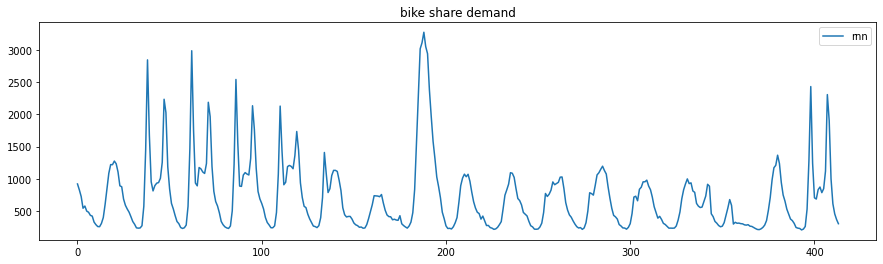

In [25]:
# 자전거 이용객수 예측값

rnn1.plot(figsize=(15,4), legend=True)
plt.legend(['rnn'])
plt.title('bike share demand')
plt.show()

In [26]:
test = np.array(test)

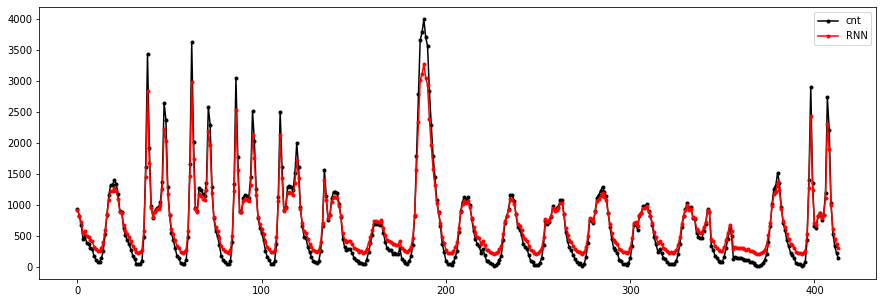

In [27]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker='.', label='RNN', color='red')
plt.legend()

In [28]:
# LSTM 모형
# 특징: 메모리 블록을 통한 장기적 기억(RNN 단점 보완)

from tensorflow.keras.layers import LSTM
lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1,1)))
lstm.add(Dense(units=1, activation='linear'))

In [29]:
# unit 개수: LSTM == RNN
# Param 수: LSTM >> RNN
# LSTM이 보다 정교하지만 과적합 문제 발생할 수 있음

print(lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 23s 1ms/step - loss: 0.0093 - mse: 0.0093
Epoch 2/2
16999/16999 [==============================] - 24s 1ms/step - loss: 0.0071 - mse: 0.0071


In [31]:
lstm = lstm.predict(X_test)
lstm = sc.inverse_transform(lstm)

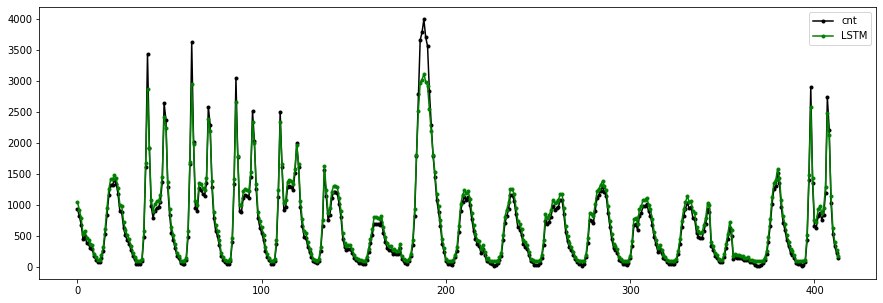

In [32]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(lstm, marker='.', label='LSTM', color='green')
plt.legend()

In [33]:
# GRU 모형
# 특징: LSTM의 과적합(오버피팅) 문제 보완(Param 개수 줄임) & 성능 유지

from tensorflow.keras.layers import GRU
gru = Sequential()
gru.add(GRU(units=6, activation='relu', input_shape=(1,1)))
gru.add(Dense(units=1, activation='linear'))

In [34]:
# unit 개수: GRU == LSTM == RNN
# Param 수: LSTM >> GRU >> RNN
# 성능은 유지하되 과적합 방지

print(gru.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6)                 162       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 26s 1ms/step - loss: 0.0098 - mse: 0.0098
Epoch 2/2
16999/16999 [==============================] - 24s 1ms/step - loss: 0.0075 - mse: 0.0075


In [36]:
gru = gru.predict(X_test)
gru = sc.inverse_transform(gru)

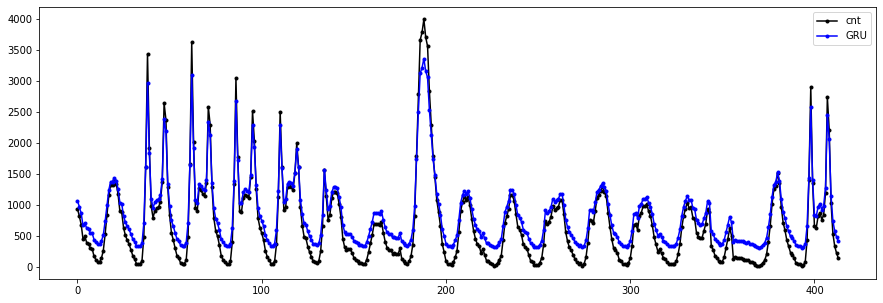

In [37]:
plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(gru, marker='.', label='GRU', color='blue')
plt.legend()

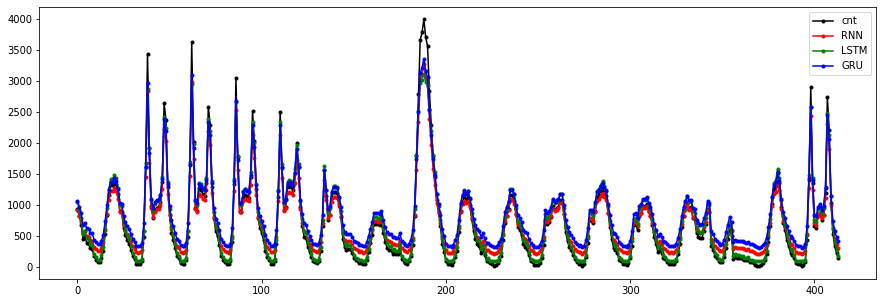

In [38]:
# 모형별 비교

plt.figure(figsize=(15,5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker='.', label='RNN', color='red')
plt.plot(lstm, marker='.', label='LSTM', color='green')
plt.plot(gru, marker='.', label='GRU', color='blue')
plt.legend()

In [39]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [40]:
print("RNN RMSE:", RMSE(test, rnn))

RNN RMSE: 166.52941775715186


In [41]:
print("LSTM RMSE:", RMSE(test, lstm))

LSTM RMSE: 126.145044374885


In [42]:
print("GRU RMSE:", RMSE(test, gru))

GRU RMSE: 228.0015861863075
